In [110]:
#hide
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [111]:
import yaml

#export
class AppConfig():
    def __init__(self, file_name):
        with open(file_name) as f:
            self.config = yaml.safe_load(f)
        self.database_user = self.config["database_user"]
        self.database_password = self.config["database_password"]
        self.database_name = self.config["database_name"]
        self.database_host = self.config["database_host"]
        self.database_port = self.config["database_port"]
        self.table_index_values_name = self.config["table_index_values_name"]
        self.table_base_rates_name = self.config["table_base_rates_name"]
        self.data_file_folder = self.config["data_file_folder"]
        
class DataFileContainer():
    def __init__(self, file_name):
        with open(file_name) as f:
            self.yaml_file = yaml.safe_load(f)
        self.index_value_files = self.yaml_file["index_data"]
        self.base_rate_files = self.yaml_file["base_rate_data"]

In [112]:
#hide
#from nbdev.showdoc import *
from IPython.display import Markdown,display
#import nb2ltx.AppConfig as AppConfig
import pyorient
import pandas as pd
import os.path
import matplotlib.pyplot as plt
import datetime as dt
import xlrd

In [113]:
def convert_excel_date(excel_date):
    return dt.datetime(*xlrd.xldate_as_tuple(excel_date, 0))

In [114]:
config = AppConfig("config.yml")

In [115]:
client = pyorient.OrientDB(config.database_host, config.database_port)
client.connect(config.database_user, config.database_password)

78

In [116]:
if client.db_exists(config.database_name):
   # Drop Database
   client.db_drop(config.database_name)
    
# Create Database
client.db_create(
  config.database_name,
  pyorient.DB_TYPE_DOCUMENT,
  pyorient.STORAGE_TYPE_PLOCAL 
)

database = client.db_open(config.database_name, config.database_user, config.database_password)

In [117]:
client.command("CREATE CLASS " + config.table_index_values_name + " IF NOT EXISTS")
client.command("CREATE CLASS " + config.table_base_rates_name + " IF NOT EXISTS")

[12]

In [118]:
def prepare_index_data(df, isin, region):
    df.columns = df.columns.str.replace(' ','_')
    df.dropna(inplace = True)
    df["ISIN"] = isin
    df["Region"] = region
    
def insert_index_data(index_value_file_list):
    current_index = 1
    for file in index_value_file_list:
        df = pd.read_csv(os.path.join(config.data_file_folder, file["file_name"]))
        prepare_index_data(df, file["isin"], file["region"])
        print("Inserting '" + file["file_name"] + "' (" + str(current_index) + " of " + str(len(index_value_file_list)) + ") (" + str(df.shape[0]) + " rows) ...")
        current_index = current_index + 1
        for index, row in df.iterrows():
            insert_command = "INSERT INTO " + config.table_index_values_name + " CONTENT " + row.to_json()
            client.command(insert_command)

In [119]:
def prepare_base_rate_data(df, institution, region):
    df.columns = df.columns.str.replace(' ','_')
    df.dropna(inplace = True, axis=1, how='all')
    df["Institution"] = institution
    df["Region"] = region
    
def insert_base_rate_data(base_rate_file_list):
    current_index = 1
    for file in base_rate_file_list:
        df = pd.read_csv(os.path.join(config.data_file_folder, file["file_name"]), sep = ';')
        prepare_base_rate_data(df, file["institution"], file["region"])
        print("Inserting '" + file["file_name"] + "' (" + str(current_index) + " of " + str(len(base_rate_file_list)) + ") (" + str(df.shape[0]) + " rows) ...")
        current_index = current_index + 1
        for index, row in df.iterrows():
            insert_command = "INSERT INTO " + config.table_base_rates_name + " CONTENT " + row.to_json()
            client.command(insert_command)

In [120]:
data_file_container = DataFileContainer("files.yml")

In [121]:
print("-- Inserting index values")
insert_index_data(data_file_container.index_value_files)
print("-- Done!")

-- Inserting index values
Inserting 'Index CAC40 (FCHI) Entwicklung.csv' (1 of 7) (7905 rows) ...
Inserting 'Index DAX Entwicklung.csv' (2 of 7) (8418 rows) ...
Inserting 'Index Dow Jones (DJI) Entwicklung.csv' (3 of 7) (5346 rows) ...
Inserting 'Index Euronext 100 (N100) Entwicklung.csv' (4 of 7) (5451 rows) ...
Inserting 'Index NASDAQ100 (NDX) Entwicklung.csv' (5 of 7) (5366 rows) ...
Inserting 'Index S&P500 Entwicklung.csv' (6 of 7) (5366 rows) ...
Inserting 'Index STOXX50E Entwicklung seit 2007.csv' (7 of 7) (3526 rows) ...
-- Done!


In [122]:
print("-- Inserting base_rate values")
insert_base_rate_data(data_file_container.base_rate_files)
print("-- Done")

-- Inserting base_rate values
Inserting 'EZB Leitzins Entwicklung.csv' (1 of 2) (48 rows) ...
Inserting 'FED Leitzins Entwicklung.csv' (2 of 2) (55 rows) ...
-- Done


In [123]:
print(client.query("SELECT FROM " + config.table_index_values_name, 10)[0])
print(client.query("SELECT FROM " + config.table_base_rates_name, 10)[0])

{'@index_value':{'Date': '1990-03-01', 'Open': 1836.0, 'High': 1838.0, 'Low': 1827.0, 'Close': 1832.0, 'Adj_Close': 1832.0, 'Volume': 0.0, 'ISIN': 'FR0003500008', 'Region': 'EU'},'version':1,'rid':'#25:0'}
{'@base_rate':{'DateSince': '1999-01-01', 'BaseRate': 3.0, 'Institution': 'EZB', 'Region': 'EU'},'version':1,'rid':'#33:0'}


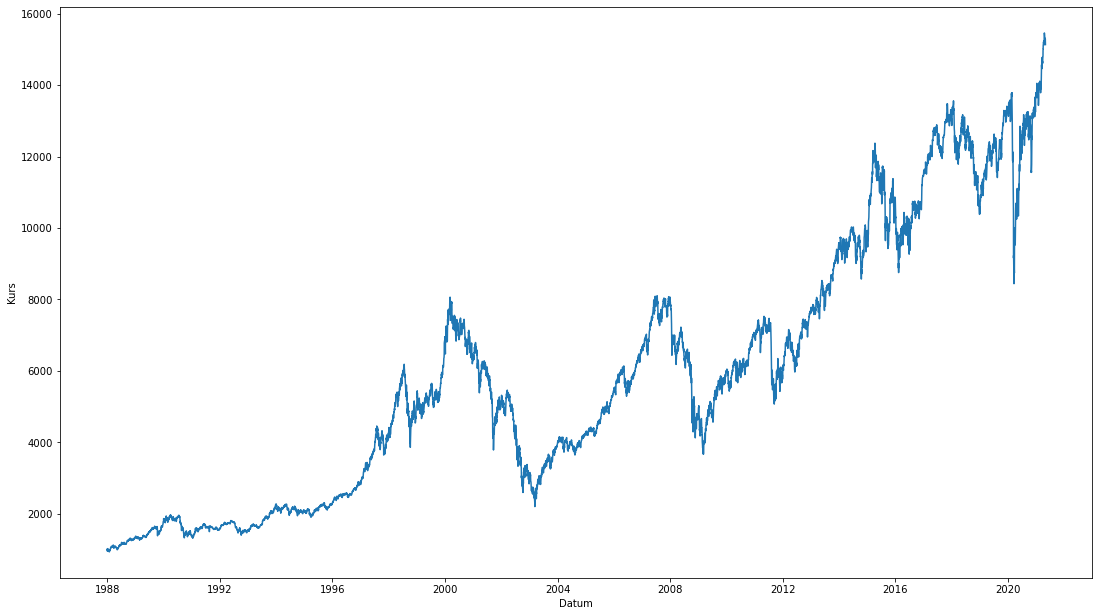

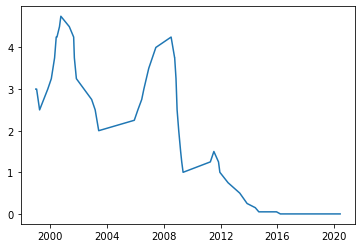

In [124]:
def get_date(entry):
    return entry["Date"]

# DAX
dax_data = list(map(lambda x: x.oRecordData, client.query('SELECT FROM ' + config.table_index_values_name + ' WHERE ISIN = "DE0008469008" ORDER BY Date ASC', -1)))
dax_data = sorted(dax_data, key=get_date)
dates = list(map(lambda x: dt.datetime.strptime(x["Date"], '%Y-%m-%d').date(), dax_data))
close_values = list(map(lambda x: x["Close"], dax_data))
plt.plot(dates, close_values)
plt.xlabel('Datum')
plt.ylabel('Kurs')
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.show()

def get_date_since(entry):
    return entry["DateSince"]

# EZB
ezb_data = list(map(lambda x: x.oRecordData, client.query('SELECT FROM ' + config.table_base_rates_name + ' WHERE Institution = "EZB" ORDER BY Date ASC', -1)))
ezb_data = sorted(ezb_data, key=get_date_since)
dates = list(map(lambda x: dt.datetime.strptime(x["DateSince"], '%Y-%m-%d').date(), ezb_data))
base_rate_values = list(map(lambda x: x["BaseRate"], ezb_data))
plt.plot(dates, base_rate_values)
plt.show()

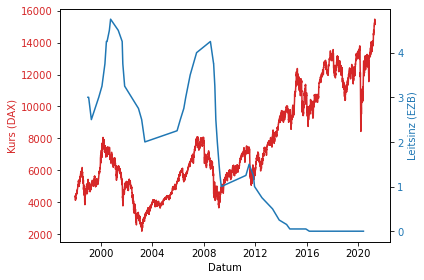

In [129]:
# DAX
dax_data = list(map(lambda x: x.oRecordData, client.query('SELECT FROM ' + config.table_index_values_name + ' WHERE ISIN = "DE0008469008" AND Date > "1998-01-01" ORDER BY Date ASC', -1)))
dax_data = sorted(dax_data, key=get_date)
dax_dates = list(map(lambda x: dt.datetime.strptime(x["Date"], '%Y-%m-%d').date(), dax_data))
close_values = list(map(lambda x: x["Close"], dax_data))

# EZB
ezb_data = list(map(lambda x: x.oRecordData, client.query('SELECT FROM ' + config.table_base_rates_name + ' WHERE Institution = "EZB" ORDER BY Date ASC', -1)))
ezb_data = sorted(ezb_data, key=get_date_since)
base_rate_dates = list(map(lambda x: dt.datetime.strptime(x["DateSince"], '%Y-%m-%d').date(), ezb_data))
base_rate_values = list(map(lambda x: x["BaseRate"], ezb_data))

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Datum')
ax1.set_ylabel('Kurs (DAX)', color=color)
ax1.plot(dax_dates, close_values, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Leitsinz (EZB)', color=color)  # we already handled the x-label with ax1
ax2.plot(base_rate_dates, base_rate_values, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()